# Question
# ResNet이란 무엇인가?

ResNet(잔차 신경망, 레스넷)은 스킵 커넥션을 이용해서 잔차를 학습하도록 만든 알고리즘으로, 일반적인 딥러닝 신경망보다 예측 정확도가 높음

* Residual(잔차) : 관측치와 회귀식의 예측치와의 차이
* Network(신경망) : 기존의 모델보다 진보된 신경망

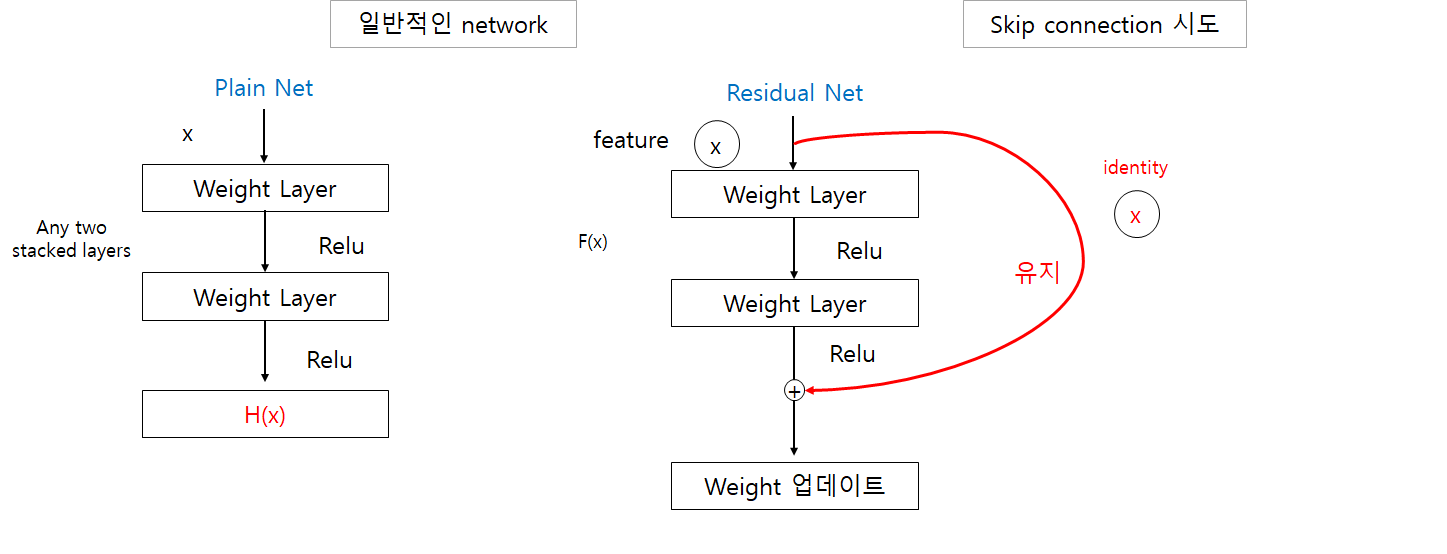

# ResNet의 특징

* 기존의 방식보다 더 빠른 Short cut을 진행시킵니다.<br>
 1) 일정 시점마다 input x 자체를 skip connection을 통해서 연결 <br>
 2) gradient flow가 원활하게 이루어짐 → weight가 변동 (모델을 깊게 쌓는 것에 대한 부담이 줄어듬) <br>

# ResNet의 사례

* 사물 이미지 분류

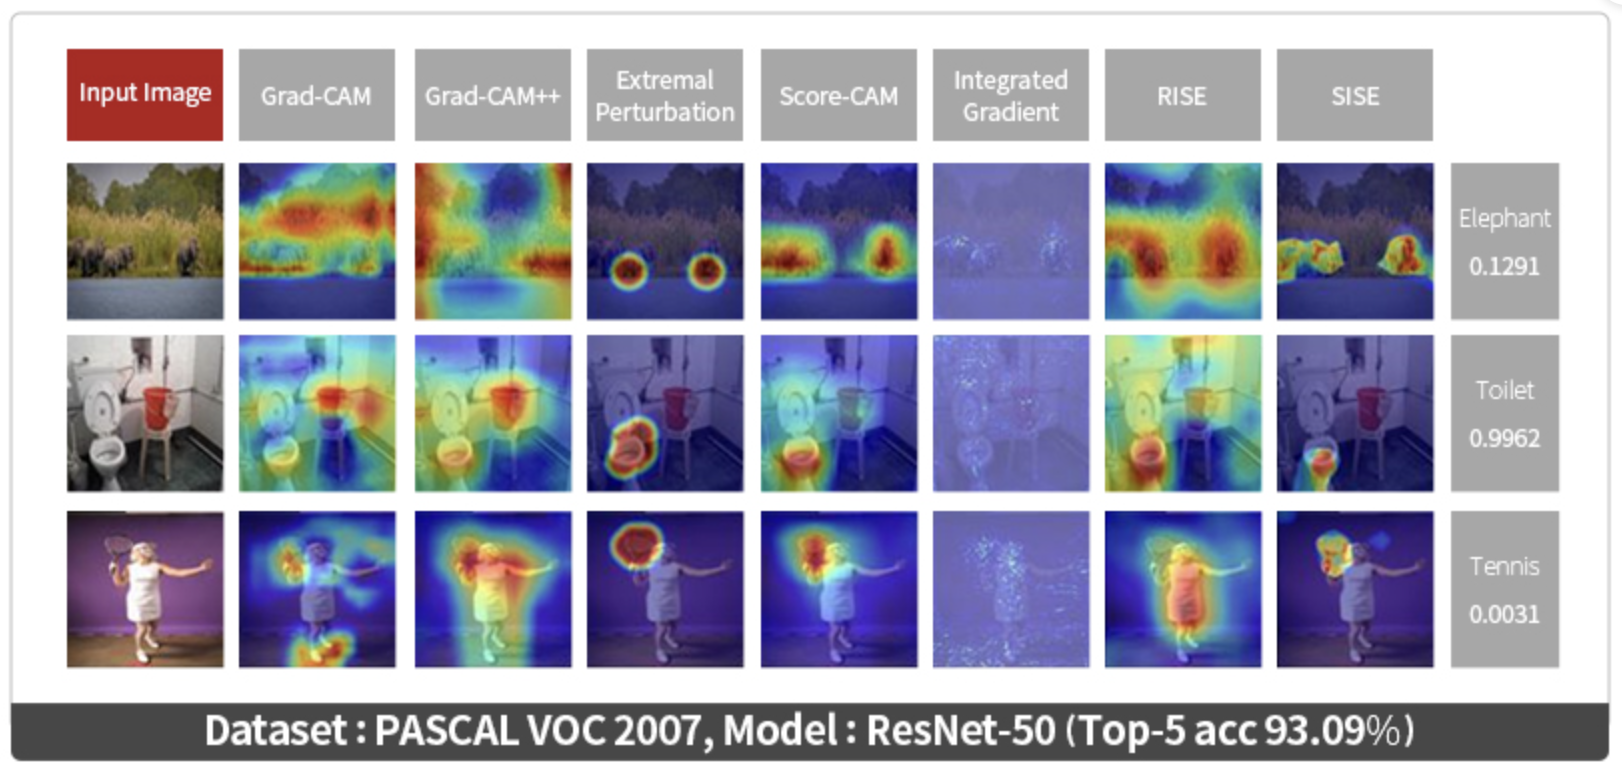

* 지하 매질 탐사
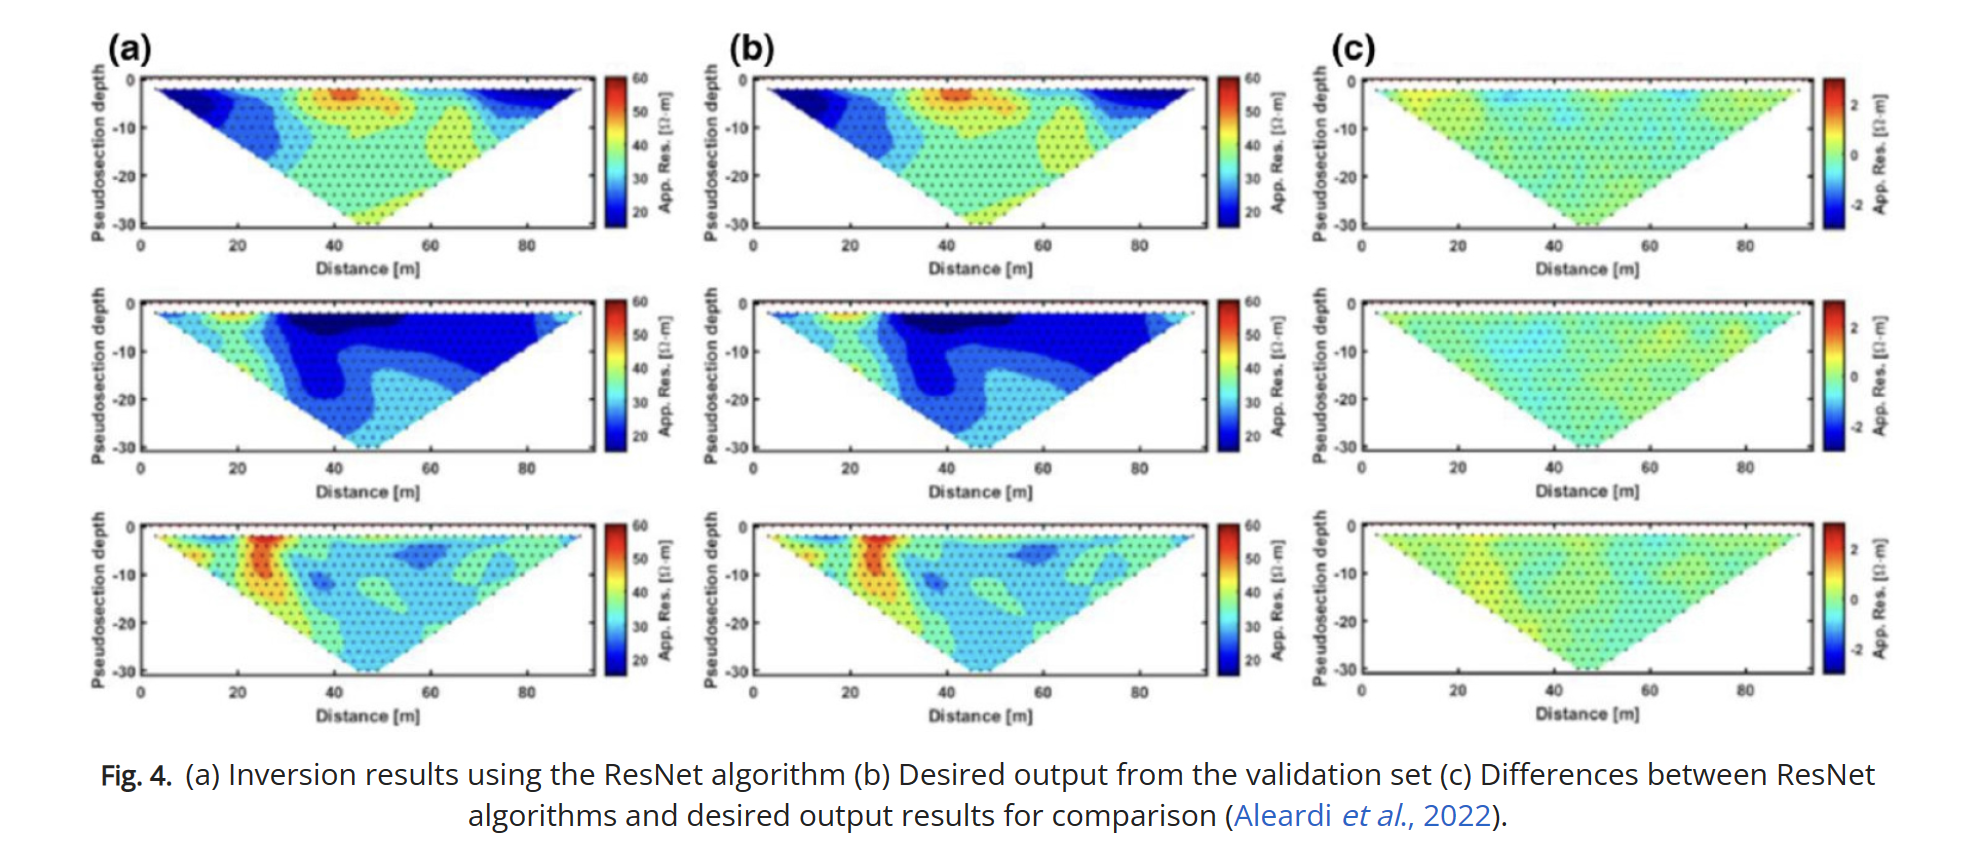

* 예측 정확도가 높아야 하는 중요한 이미지 분석에서 사용됩니다.

# 이번에 우리가 사용할 모델 : ResNet 50

# 가상환경에 필요한 패키지 설치

In [2]:
!pip install -q torchsummary
!pip -q install jcopdl

  Preparing metadata (setup.py) ... done


# 패키지 로드

In [3]:
# pytorch 관련 패키지
import torch
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision import models


# 배열 수정 관련
import numpy as np
import pandas as pd

# 시각화
import matplotlib.pyplot as plt
from PIL import Image


# 그외 파이썬 기본
from tqdm.auto import tqdm
from time import sleep
import os
import random

# jcopdl 관련
import jcopdl
from jcopdl.callback import Callback

# 경고 메시지 무시
import warnings
warnings.filterwarnings(action='ignore')

# CUDA 사용

In [4]:
USE_CUDA = torch.cuda.is_available()
device= torch.device("cuda" if USE_CUDA else "cpu")
print(f"Using Device : {device}")

Using Device : cuda


# 데이터 로드 (kaggle에서 colab으로 json 사용)

In [5]:
from google.colab import files
!pip install -q kaggle #kaggle 설치

files.upload() 
!mkdir ~/.kaggle 
!cp kaggle.json ~/.kaggle/ 
!chmod 600 ~/.kaggle/kaggle.json 

# https://www.kaggle.com/datasets/vishalsubbiah/pokemon-images-and-types
!kaggle datasets download -d vishalsubbiah/pokemon-images-and-types

Saving kaggle.json to kaggle.json
 81% 2.00M/2.47M [00:01<00:00, 2.23MB/s]
100% 2.47M/2.47M [00:01<00:00, 2.32MB/s]


In [ ]:
# 번역한 pokemon_name.csv 파일 다운로드 링크 (pokemon_name 있으면 생략)
# http://naver.me/5cAx5gK0

In [6]:
# pokemon_name 파일이 인코딩 오류로 구글 드라이브에서 직접 다운
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# 알집파일 압축 해제
!unzip /content/pokemon-images-and-types.zip

Archive:  /content/pokemon-images-and-types.zip
  inflating: images/images/abomasnow.png  
  inflating: images/images/abra.png  
  inflating: images/images/absol.png  
  inflating: images/images/accelgor.png  
  inflating: images/images/aegislash-blade.png  
  inflating: images/images/aerodactyl.png  
  inflating: images/images/aggron.png  
  inflating: images/images/aipom.png  
  inflating: images/images/alakazam.png  
  inflating: images/images/alomomola.png  
  inflating: images/images/altaria.png  
  inflating: images/images/amaura.png  
  inflating: images/images/ambipom.png  
  inflating: images/images/amoonguss.png  
  inflating: images/images/ampharos.png  
  inflating: images/images/anorith.png  
  inflating: images/images/araquanid.jpg  
  inflating: images/images/arbok.png  
  inflating: images/images/arcanine.png  
  inflating: images/images/arceus.png  
  inflating: images/images/archen.png  
  inflating: images/images/archeops.png  
  inflating: images/images/ariados.png 

In [8]:
# csv 로드를 위한 경로 설정
WORKING_DIR = "/content/"
INFO_DIR = "drive/MyDrive/pokemon_name.csv"
IMAGES_DIR = "images/images/"

# 포켓몬 이름 데이터 확인

In [9]:
# pokemon 한글이름 데이터 확인
df = pd.read_csv(INFO_DIR, encoding = 'cp949')
df.head(12)

EnglishName KoreanName
0    bulbasaur       이상해씨
1      ivysaur       이상해풀
2     venusaur       이상해꽃
3   charmander        파이리
4   charmeleon        리자드
5    charizard        리자몽
6     squirtle        꼬부기
7    wartortle       어니부기
8    blastoise        거북왕
9     caterpie        캐터피
10     metapod        단데기
11  butterfree        버터플

In [10]:
# 안전성을 위해서 데이터프레임 카피

df2 = df.copy()

# 모델에 활용하기 위한 포켓몬 데이터셋 제작
## = 데이터 전처리
* OneHotEncoder, LabelEncoder 사용
* 721번 부터 이미지 파일 형식이 상이(png, jpg)파일을 따로 구분해준다

In [11]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [12]:
# 포켓몬 데이터셋 준비

class PokemonDatasetBuilder():
    def __init__(self, dataset_class, file_path, transform=None, splits=True):
        
        self._splits = splits
        self._dataset_class = dataset_class
        self.df = pd.read_csv(file_path, encoding = 'cp949')
        self.transform = transform
        self._preprocess_frame()
        
    def __call__(self, test_split=0.1, val_split=0.1):
        
        dfs = []
        if self._splits:
            dfs.extend(self._create_splits(test_split, val_split))
        else:
            dfs.append(self.df)
        
        datasets = []
        
        if self._dataset_class == "multilabel":
            OHE = OneHotEncoder(sparse=False, handle_unknown="ignore")
            OHE.fit(self.df[["EnglishName"]])
            
            for df in dfs:
                datasets.append(PokemonDatasetMultilabel(df, OHE, self.transform))

        else:
            LE1 = LabelEncoder()
            LE2 = LabelEncoder()
            
            LE1.fit(self.df["EnglishName"])
            LE2.fit(self.df["KoreanName"])
        
            for df in dfs:
                datasets.append(PokemonDatasetMulticlass(df, LE1, LE2, self.transform))
        
        return datasets
            
            
    def _create_splits(self, test_split, val_split):

        df_test = self.df.sample(frac=test_split, random_state=42)
        df_train = self.df.drop(df_test.index)
        df_val = df_train.sample(frac=val_split, random_state=42)
        df_train = df_train.drop(df_val.index)

            
        return [df_train, df_val, df_test]

    
    def _preprocess_frame(self):

        self.df["EnglishName"].iloc[:721] = self.df["EnglishName"].iloc[:721].apply(lambda x : x + ".png")
        self.df["EnglishName"].iloc[721:] = self.df["EnglishName"].iloc[721:].apply(lambda x : x + ".jpg")
        self.df["EnglishName"].fillna("None", inplace=True)

In [13]:
class PokemonDatasetMultilabel(Dataset):
    def __init__(self, df, encoder, transform=None):
        
        self.df = df
        self.transform = transform
        self.encoder = encoder
        self.type1 = encoder.transform(self.df[["EnglishName"]]) 
        self.type2 = encoder.transform(self.df[["KoreanName"]]) 
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        image_file = WORKING_DIR + IMAGES_DIR + self.df.iloc[idx, 0]
        
        image = process_image(image_file, self.transform)

        return image, (self.type1[idx] + self.type2[idx])

    
    def __len__(self):
        return self.df.shape[0]
    
    
    def get_labels_from_vector(self, vector):

        labels = self.encoder.categories_[0][vector==1]
        if vector.sum() == 1:
            return labels[0], "None"
        else:
            return tuple(labels)

    def get_labels_from_id(self, type1, type2=None):

        if type2 is not None: 
            return self.encoder.categories_[0][type1], self.encoder.categories_[0][type2]
        else:
            return self.encoder.categories_[0][type2] 

In [14]:
class PokemonDatasetMulticlass(Dataset):

    def __init__(self, df, type_1_encoder, type_2_encoder, transform=None):
        
        self.df = df
        self.transform = transform
        
        self.type_1_encoder = type_1_encoder
        self.type_2_encoder = type_2_encoder
        
        self.type1 = type_1_encoder.transform(self.df["EnglishName"])
        self.type2 = type_2_encoder.transform(self.df["KoreanName"])
        
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        image_file = WORKING_DIR + IMAGES_DIR + self.df.iloc[idx, 0]
        image = process_image(image_file, self.transform)
        
        return image, self.type1[idx], self.type2[idx]
    
    def __len__(self):
        return self.df.shape[0]
    
    
    
    def get_labels(self, type1, type2):

        return self.type_1_encoder.classes_[type1], self.type_2_encoder.classes_[type2]

                
def process_image(image_file, transform=None):

    if image_file.split(".")[-1] == "png":
        pil_image = Image.open(image_file).convert("RGBA")
        image = Image.new('RGBA',pil_image.size,(255,255,255))
        image.paste(pil_image, (0,0), pil_image)
        image = image.convert("RGB")

    else:
        image = Image.open(image_file)


    if transform:
        image = transform(image)
        
    return image

# 이미지 호출을 위한 함수 선언

In [15]:
def show_image(image, type1, type2):

    plt.imshow(image.permute(1, 2, 0))
    plt.axis("Off")
    title = f"{type1}"
    if type2 != "None":
        title += f", {type2}"
    plt.title(title[:-4])

    for i in list(train_dataset.get_labels_from_vector(pokemon[1]))[:1]:
        english_name = i[0:-4]
    for i in df['KoreanName'][(df['EnglishName']==english_name)].values:
        print("이 포켓몬의 이름은?", i, '\n')
        name_kor = i


# 이미지 transformation, generator

In [16]:
OUTPUT_TYPE = "multilabel" 

transformations = transforms.Compose([transforms.Resize((120, 120)), transforms.ToTensor()])
# transformations = transforms.Compose([transforms.ToTensor()])
dataset_generator = PokemonDatasetBuilder(OUTPUT_TYPE, WORKING_DIR+INFO_DIR, transformations)
train_dataset, val_dataset, test_dataset = dataset_generator()

train_dataloader = DataLoader(train_dataset, batch_size = 4, shuffle=True)
val_dataloader = DataLoader(val_dataset)
test_dataloader = DataLoader(test_dataset)

In [17]:
dataset_generator()

In [18]:
train_dataset[0][0].shape

torch.Size([3, 120, 120])

# 데이터중 하나만 이미지 출력

이 포켓몬의 이름은? 터검니 



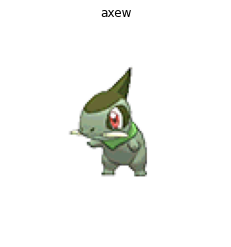

In [20]:
# 랜덤한 포켓몬
i = random.randint(1, 650)
pokemon = train_dataset[i]
show_image(pokemon[0], *train_dataset.get_labels_from_vector(pokemon[1]))

# Sample usage for multiclass
# show_image(pokemon[0], *train_dataset.get_labels(*pokemon[1:]))

# 모델 생성


In [21]:
class UnknownModeException(Exception):
    
    def __str__(self):
        return "Unknown mode given. Use one of: 'logistic', 'softmax', 'none'."  
        

In [22]:
class PokemonFCBlock(nn.Module):
    
    def __init__(self, in_features, out_features, mode="none", dropout=0.2):

        super().__init__()
        
        self.fc = nn.Sequential(
            nn.Linear(in_features, 1000),
            nn.LeakyReLU(),
            nn.Dropout(dropout),
            nn.Linear(1000, 1000),
            nn.LeakyReLU(), 
            nn.Dropout(dropout),
            nn.Linear(1000, out_features)
        )
        
        self.mode = mode.lower()
        
        
    def forward(self, x):
        
        if self.mode == "logistic":

            return torch.sigmoid(self.fc(x))

        elif self.mode == "softmax":

            return F.softmax(self.fc(x))

        elif self.mode == "none":

            return self.fc(x)

        else:

            raise UnknownModeException

In [23]:
class PokemonMultilabelCNN(nn.Module):
    
    def __init__(self, base_model, output_size, dropout):
        
        super().__init__()
    
        self.base_model = base_model 

        in_features = self.base_model.fc.in_features

        new_final = PokemonFCBlock(in_features, output_size, mode="logistic")

        self.base_model.fc = new_final
        
    def forward(self, x):

        return self.base_model(x)
    
    def freeze(self):

        for name, child in self.base_model.named_children():

            if name != "fc":

                for param in child.parameters():

                    param.requires_grad = False 
            
    def unfreeze(self):

        for param in self.base_model.parameters():
          
            param.requires_grad = True 

# ResNet 모델 다운로드 (pretrained 됨)

In [ ]:
# 다운로드한 모델 확인

In [24]:
base_model = models.resnet50(pretrained=True, progress=False)

model = PokemonMultilabelCNN(base_model, 809, 0.5) # dropout = 0.5부터 테스트 시작

model.to(device)

model.freeze()

base_model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [25]:
# model_summary 예시
summary(model, (3, *(120,120)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 60, 60]           9,408
       BatchNorm2d-2           [-1, 64, 60, 60]             128
              ReLU-3           [-1, 64, 60, 60]               0
         MaxPool2d-4           [-1, 64, 30, 30]               0
            Conv2d-5           [-1, 64, 30, 30]           4,096
       BatchNorm2d-6           [-1, 64, 30, 30]             128
              ReLU-7           [-1, 64, 30, 30]               0
            Conv2d-8           [-1, 64, 30, 30]          36,864
       BatchNorm2d-9           [-1, 64, 30, 30]             128
             ReLU-10           [-1, 64, 30, 30]               0
           Conv2d-11          [-1, 256, 30, 30]          16,384
      BatchNorm2d-12          [-1, 256, 30, 30]             512
           Conv2d-13          [-1, 256, 30, 30]          16,384
      BatchNorm2d-14          [-1, 256,

In [26]:
# 패러미터 조정. callback은 미사용
# optimizer 조정

criterion = nn.CrossEntropyLoss() # 초기 BCELoss
optimizer= torch.optim.Adam(model.parameters(), lr=0.0001) # 최초 ADAMW(lr =  5e-4, weight decay는 미설정)

# 모델 트레이너 선언

In [27]:
class ModelTrainer():

    
    def __init__(self, model, optimizer, criterion, device):
        
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        # self.callback = callback
        self.epoch = 1
        
    def train_loop(self, dataloader, epoch=100):

        raise NotImplementedError
        
    def validate_loop(self, dataloader):

        raise NotImplementedError
        
    def train(self, train_dataloader, val_dataloader):

        raise NotImplementedError

In [28]:
class MultilabelModelTrainer(ModelTrainer):

    
    def __init__(self, model, optimizer, criterion, device):
        
        super(MultilabelModelTrainer, self).__init__(model, optimizer, criterion, device)
    
        
    def train_loop(self, dataloader, epoch=100):
        
        self.model.train()
        cost = 0 
        t = tqdm(dataloader)
        if epoch:
            t.set_description(f"Training mode, Epoch {self.epoch}")
            
        for feature, target in t:
            feature, target = feature.to(self.device), target.to(self.device)
            output = self.model(feature).double() 
            loss = self.criterion(output, target)
            loss.backward()
            
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            cost += loss.item() * feature.shape[0]
        
        return cost / len(dataloader.dataset)
            
        
    def validate_loop(self, dataloader):
        
        self.model.eval()
        cost = 0
        with torch.no_grad():
            for feature, target in tqdm(dataloader, desc="Validation mode"):
                feature, target = feature.to(self.device), target.to(self.device)
                output = self.model(feature).double()
                loss = self.criterion(output, target)
                
                cost += loss.item() * feature.shape[0]
        
        return cost/len(dataloader.dataset)
        
        
    def train(self, train_dataloader, val_dataloader):
        
        for _ in range(1, 100):
            train_cost = self.train_loop(train_dataloader)
            val_cost = self.validate_loop(val_dataloader)
            self.epoch += 1
                      
            print(f'1) 학습 cost : {train_cost},\n2) 검증 cost : {val_cost}')
            

# 아래부터 학습 시작
> pt 저장도 함께 됩니다.<br>

> 작동시간
* epoch 50회 작동시 = 3분 30초
* epoch 100회 작동시 = 7분

In [29]:
# 시간 체크
# 에포크 숫자가 따로 표시

model_trainer = MultilabelModelTrainer(model, optimizer, criterion, device) # (시간 꼭 체크)
model_trainer.train(train_dataloader, val_dataloader)
torch.save(model.state_dict(), "pokemon_epoch_Cross_entropy_loss_ADAM_LR=0.0001(100회).pt")

  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.71512144045968,
2) 검증 cost : 6.710735060538509


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.697603519794104,
2) 검증 cost : 6.771277242836264


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.682256230191045,
2) 검증 cost : 6.814428548294022


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.668989149745603,
2) 검증 cost : 6.841369213445911


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.659034492759686,
2) 검증 cost : 6.876696153284822


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.6498973147947575,
2) 검증 cost : 6.9000551497921006


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.640875389445731,
2) 검증 cost : 6.913171859760627


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.632375011536326,
2) 검증 cost : 6.9178264650323245


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.619365208223244,
2) 검증 cost : 6.920357616335085


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.6077663700773375,
2) 검증 cost : 6.910583813706182


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.592144297950646,
2) 검증 cost : 6.902908756069694


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.580333559424029,
2) 검증 cost : 6.905681373666106


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.559217254279092,
2) 검증 cost : 6.90544626027757


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.539871954136328,
2) 검증 cost : 6.910188173433841


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.521460208910773,
2) 검증 cost : 6.909583393883927


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.482888789873114,
2) 검증 cost : 6.9365841971334685


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.445040847036923,
2) 검증 cost : 6.993900183419522


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.402825470977363,
2) 검증 cost : 7.031878562506079


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.353928511622504,
2) 검증 cost : 7.0478979804248105


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.313367632343425,
2) 검증 cost : 7.074881615378493


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.2745705385651105,
2) 검증 cost : 7.0225812887756875


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.238418916795808,
2) 검증 cost : 7.037251183302785


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.209372520300735,
2) 검증 cost : 7.004167005778432


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.171662526837784,
2) 검증 cost : 7.005221683988916


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.170101662553259,
2) 검증 cost : 7.032298421686152


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.1592541955748406,
2) 검증 cost : 6.971886960754422


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.139863982676269,
2) 검증 cost : 7.002508154808605


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.138418619038529,
2) 검증 cost : 7.0019428482639325


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.100407584460941,
2) 검증 cost : 6.994022285815388


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.080775059361183,
2) 검증 cost : 6.950034113754391


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.076596140841109,
2) 검증 cost : 6.9841833459188525


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.071383962147484,
2) 검증 cost : 7.00683414485566


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.0551966959503885,
2) 검증 cost : 6.9482400816593275


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.055587156705787,
2) 검증 cost : 6.941444386099324


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.025342791938539,
2) 검증 cost : 6.937570784798865


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.0325283312577485,
2) 검증 cost : 6.9596748248089755


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.038627198480371,
2) 검증 cost : 6.901768359214776


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.0138910572023505,
2) 검증 cost : 6.89278378509316


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 6.022248348256277,
2) 검증 cost : 6.932012150857078


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.998806463205061,
2) 검증 cost : 6.863243837903246


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.996387028276942,
2) 검증 cost : 6.9294996544378105


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.995525085489358,
2) 검증 cost : 6.889541476345796


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.990170629878515,
2) 검증 cost : 6.906983690877088


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.998049982753987,
2) 검증 cost : 6.89540730589036


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.998217122848376,
2) 검증 cost : 6.8776380017345025


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.989760580960292,
2) 검증 cost : 6.858522265143017


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.962981783067526,
2) 검증 cost : 6.842499280828252


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.9824834021150375,
2) 검증 cost : 6.883236877679685


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.988117140747337,
2) 검증 cost : 6.877493123535816


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.956639443622239,
2) 검증 cost : 6.854637924959446


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.943181557317668,
2) 검증 cost : 6.87017426624283


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.970706136678908,
2) 검증 cost : 6.845022834867492


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.970941352932426,
2) 검증 cost : 6.836931551110796


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.958869460558353,
2) 검증 cost : 6.859752056441234


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.9461696370602475,
2) 검증 cost : 6.866993200736262


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.944474235554787,
2) 검증 cost : 6.828640965014137


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.938695542727991,
2) 검증 cost : 6.883792709452856


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.946712024007875,
2) 검증 cost : 6.862164158463001


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.947347961420011,
2) 검증 cost : 6.826702973398499


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.936377239909707,
2) 검증 cost : 6.820908403803737


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.946307897136424,
2) 검증 cost : 6.8283479398462195


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.941441867417673,
2) 검증 cost : 6.832767829162979


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.922336113368541,
2) 검증 cost : 6.8598017547573304


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.930667977713684,
2) 검증 cost : 6.831414095447472


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.911021605698773,
2) 검증 cost : 6.858569770263179


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.947036526922351,
2) 검증 cost : 6.811334339859206


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.910205538782319,
2) 검증 cost : 6.857573438172329


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.911848905498867,
2) 검증 cost : 6.8207748350984545


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.903891900250896,
2) 검증 cost : 6.824963735663094


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.906475489161559,
2) 검증 cost : 6.8222191960511624


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.91708205025073,
2) 검증 cost : 6.839168309197953


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.914991490231315,
2) 검증 cost : 6.833283627738748


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.915777681980698,
2) 검증 cost : 6.826485808306547


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.889683908525578,
2) 검증 cost : 6.810013609166387


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.905142164127564,
2) 검증 cost : 6.8182535911376


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.916341700948392,
2) 검증 cost : 6.8095265060903865


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.903586899787151,
2) 검증 cost : 6.81826805688238


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.899677937934255,
2) 검증 cost : 6.8189380321526345


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.916183121045047,
2) 검증 cost : 6.831634165151999


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.904440924316128,
2) 검증 cost : 6.824972496814965


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.907039056283837,
2) 검증 cost : 6.820442505683269


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.8842406562067895,
2) 검증 cost : 6.806687734685326


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.887882967121555,
2) 검증 cost : 6.786350627055484


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.872747243268185,
2) 검증 cost : 6.800824045011491


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.884920007127379,
2) 검증 cost : 6.8127808174899


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.880197571652103,
2) 검증 cost : 6.778384370506365


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.885319003061343,
2) 검증 cost : 6.805804238049483


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.8867444639327235,
2) 검증 cost : 6.80626068393557


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.880799399966409,
2) 검증 cost : 6.809173353958597


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.880834391680732,
2) 검증 cost : 6.811161541979108


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.8662270358355215,
2) 검증 cost : 6.807611186739769


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.888475954695924,
2) 검증 cost : 6.831940003132218


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.861889460525047,
2) 검증 cost : 6.797684146307241


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.88850560150447,
2) 검증 cost : 6.814498920636055


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.876101228022376,
2) 검증 cost : 6.794347740935944


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.874104655617871,
2) 검증 cost : 6.837975000744021


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.882563181146981,
2) 검증 cost : 6.788568104730313


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.880683897147176,
2) 검증 cost : 6.816980311454754


  0%|          | 0/164 [00:00<?, ?it/s]

Validation mode:   0%|          | 0/73 [00:00<?, ?it/s]

1) 학습 cost : 5.8497109004839,
2) 검증 cost : 6.771022521110077


In [33]:
train_dataloader

In [34]:
df.head(10)

EnglishName KoreanName
0   bulbasaur       이상해씨
1     ivysaur       이상해풀
2    venusaur       이상해꽃
3  charmander        파이리
4  charmeleon        리자드
5   charizard        리자몽
6    squirtle        꼬부기
7   wartortle       어니부기
8   blastoise        거북왕
9    caterpie        캐터피

# 모델 로드

In [35]:
model.load_state_dict(torch.load("/content/pokemon_epoch_Cross_entropy_loss_ADAM_LR=0.0001(100회).pt", map_location=device))

model

PokemonMultilabelCNN(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

# prediction

In [36]:
with torch.no_grad():
    feature = pokemon[0].to(device)
    prediction = model(feature.unsqueeze(0))
prediction

tensor([[3.0084e-16, 7.5179e-05, 1.5764e-08, 1.3320e-15, 9.8072e-02, 1.0657e-10,
         7.0765e-13, 2.2000e-16, 1.9284e-03, 4.0653e-16, 2.1573e-06, 1.5508e-13,
         7.5513e-04, 8.7980e-15, 9.6512e-01, 1.1453e-23, 3.7301e-05, 2.4444e-16,
         7.6108e-01, 3.0287e-04, 1.0301e-06, 3.1165e-02, 5.3047e-09, 2.4524e-07,
         2.3998e-15, 2.4679e-17, 5.3079e-12, 1.0996e-15, 5.2461e-16, 5.0981e-10,
         6.1102e-12, 4.7310e-12, 7.5173e-06, 2.8031e-13, 2.2392e-16, 1.9755e-13,
         5.1995e-07, 3.3066e-08, 1.1533e-24, 3.4853e-16, 1.9028e-06, 1.9545e-05,
         2.9269e-13, 2.6479e-04, 1.8117e-07, 1.7069e-08, 5.7710e-11, 2.5550e-04,
         1.1863e-13, 4.6130e-18, 6.3555e-01, 7.1482e-03, 3.6834e-16, 1.6316e-12,
         1.2733e-04, 2.0710e-16, 3.7276e-01, 5.9104e-04, 5.3755e-16, 1.6873e-11,
         2.6409e-04, 6.5476e-05, 3.3995e-01, 5.3100e-15, 8.1748e-05, 2.7657e-06,
         2.3343e-13, 2.5671e-23, 1.5798e-11, 1.6965e-12, 2.1984e-05, 3.8463e-16,
         2.4196e-03, 4.1810e

# 모델과 이미지 표현

>>>>>>>>[ 5 ]번째 포켓몬
이 포켓몬의 이름은? 리자몽 



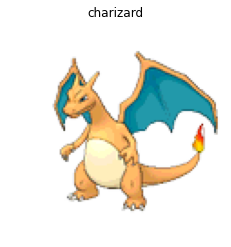

In [37]:
#@title 포켓몬 번호를 입력해볼까요?
번호를_입력해요 = 5 #@param {type:"number"}
pokemon = train_dataset[번호를_입력해요]
with torch.no_grad():
    feature = pokemon[0].to(device)
    prediction = model(feature.unsqueeze(0))
print(f'>>>>>>>>[ {번호를_입력해요} ]번째 포켓몬')
show_image(pokemon[0], *train_dataset.get_labels_from_vector(pokemon[1]))

이 포켓몬의 이름은? 리자몽 



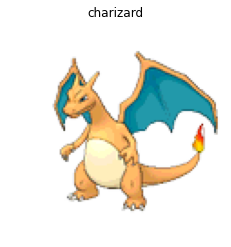

In [38]:
show_image(pokemon[0], *train_dataset.get_labels_from_vector(pokemon[1]))